In [2]:
#setting up colab for downloading kaggle datasets directly
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification #download the dataset

 97% 336M/346M [00:06<00:00, 79.7MB/s]
100% 346M/346M [00:06<00:00, 57.7MB/s]


In [0]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from tensorflow.keras import initializers
from sklearn.metrics import classification_report

In [5]:
#extract the data
for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
      print('done')

done


In [0]:
train_dir = '/content/seg_train/seg_train'
val_dir = '/content/seg_test/seg_test'
#os.listdir(train_dir)

In [7]:
print('Training data distribution\n')
for class_folder in os.listdir(train_dir):
  print(class_folder, '->', str(len(os.listdir(train_dir+'/'+class_folder))), ' images')
print('\nValidation Data distribution\n')
for class_folder in os.listdir(val_dir):
  print(class_folder, '->', str(len(os.listdir(val_dir+'/'+class_folder))), ' images')

Training data distribution

street -> 2382  images
mountain -> 2512  images
glacier -> 2404  images
sea -> 2274  images
buildings -> 2191  images
forest -> 2271  images

Validation Data distribution

street -> 501  images
mountain -> 525  images
glacier -> 553  images
sea -> 510  images
buildings -> 437  images
forest -> 474  images


In [0]:
#initialize data generators and used image augmentation for reducing overfitting ->image rotation, shear, zoom , horizontal flipping, height and width reduction
train_gen = ImageDataGenerator(rescale=1/255.0, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1/255.0, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)

In [48]:
#provide the directories for the generators
train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', color_mode='grayscale')
val_data = val_gen.flow_from_directory(directory=val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False, color_mode='grayscale')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
#monitor the categorical accuracy for every epoch and stop training if accuracy doesnt improve by 1% with patience of 5 epochs. Restore the model weights with the
#highest training accuracy
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True) 

In [0]:
num_classes = train_data.num_classes #find number of classes of data
kernel_init = initializers.he_normal() #he_normal and glorot_uniform(xavier initialization) can be chosen
kernel_reg = tf.keras.regularizers.l2(0.0009) # use l2 regularization to avoid overfitting
#initialize the model
model = tf.keras.models.Sequential([ #use (2, 2) strides in Conv2D layer to eliminate use of MaxPooling layer
                                    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', input_shape=(150, 150, 1), padding='same', kernel_initializer=kernel_init),
                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=kernel_init),
                                    tf.keras.layers.Conv2D(128, (3, 3),strides=(2, 2), activation='relu', padding='same', kernel_initializer=kernel_init),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', kernel_initializer=kernel_init),
                                    tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', kernel_initializer=kernel_init),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [0]:
opti = tf.keras.optimizers.Adam(learning_rate=0.0009) #Adam optimizer with 0.0005 learning rate. beta1 and beta2 must remain the same. 
#use sparse_categorical_crossentropy as loss function if an image belongs to a single class/label and labels are integers. 
#use categorical_crossentropy if an image belongs to multiple classes
model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision()]) 

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 38, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 19, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 256)         295168    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 512)         1180160   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 512)        

In [54]:
history = model.fit(train_data, epochs=30, steps_per_epoch=439, validation_data=val_data, validation_steps=94, callbacks=[early_stop]) #model.fit supports generators

Epoch 1/30
439/439 [==============================] - 56s 128ms/step - loss: 1.2551 - categorical_accuracy: 0.4846 - precision_1: 0.6486 - val_loss: 0.9664 - val_categorical_accuracy: 0.5963 - val_precision_1: 0.6975
Epoch 2/30
439/439 [==============================] - 56s 129ms/step - loss: 0.9286 - categorical_accuracy: 0.6395 - precision_1: 0.7300 - val_loss: 0.8966 - val_categorical_accuracy: 0.6543 - val_precision_1: 0.7160
Epoch 3/30
439/439 [==============================] - 57s 129ms/step - loss: 0.7747 - categorical_accuracy: 0.7125 - precision_1: 0.7711 - val_loss: 0.7245 - val_categorical_accuracy: 0.7420 - val_precision_1: 0.7781
Epoch 4/30
439/439 [==============================] - 56s 129ms/step - loss: 0.7164 - categorical_accuracy: 0.7333 - precision_1: 0.7895 - val_loss: 0.6532 - val_categorical_accuracy: 0.7537 - val_precision_1: 0.7965
Epoch 5/30
439/439 [==============================] - 56s 128ms/step - loss: 0.6442 - categorical_accuracy: 0.7656 - precision_1: 0.

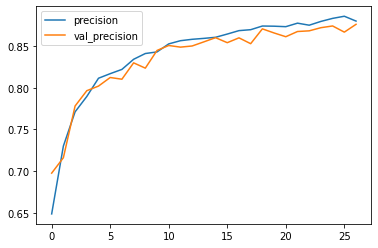

In [56]:
plt.plot(history.history['precision_1'], label='precision')
plt.plot(history.history['val_precision_1'], label='val_precision')
plt.legend()
plt.show()

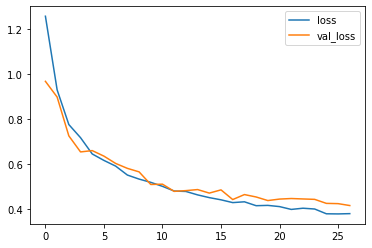

In [57]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

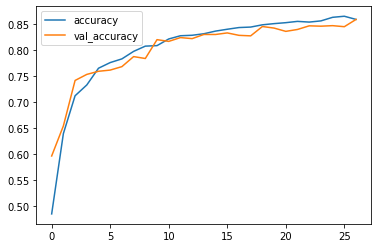

In [58]:
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [0]:
pred_dir = '/content/seg_pred/seg_pred'

In [59]:
val_data.reset()
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis = 1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   buildings       0.84      0.86      0.85       437
      forest       0.94      0.97      0.95       474
     glacier       0.73      0.86      0.79       553
    mountain       0.87      0.66      0.76       525
         sea       0.87      0.83      0.85       510
      street       0.85      0.89      0.87       501

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.84      3000
weighted avg       0.85      0.84      0.84      3000



In [0]:
def image_display(img_path):
  img=mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  plt.show()

In [0]:
def predict(img_path):
  #img = image.load_img(img_path, target_size=(150, 150))
  img = Image.open(img_path).convert('LA')
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  return pred

In [0]:
def find(classes, index):
  for key, value in classes.items():
    if value == index:
      return key

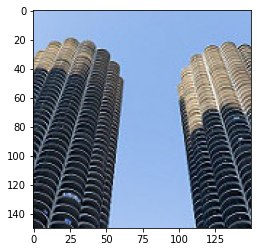

buildings


In [27]:
preds = []
val_data.reset()
classes = val_data.class_indices
path = pred_dir+'/3049.jpg'
image_display(path)
pred = np.argmax(predict(path), axis=1)
find(classes , pred)

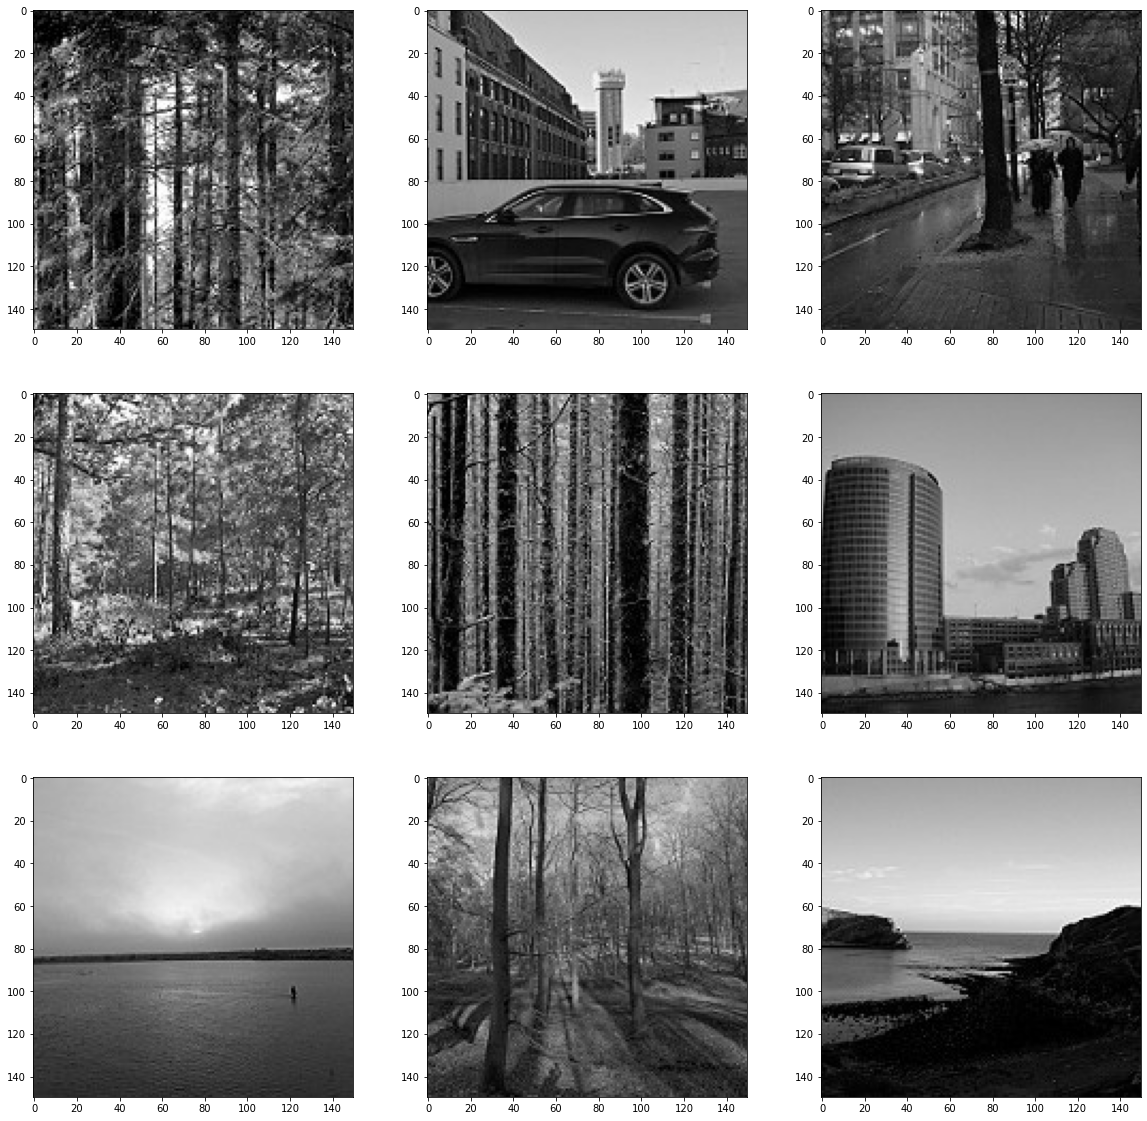

In [65]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 3
classes = val_data.class_indices
ind = 0
img_dir = [pred_dir+'/'+i for i in os.listdir(pred_dir)[20:40]]
for i in range(1, columns*rows +1):
    #img = mpimg.imread(img_dir[ind])
    img = Image.open(img_dir[ind]).convert('LA')
    ax = fig.add_subplot(rows, columns, i)
    #text = find(classes, np.argmax(predict(img_dir[ind]), axis=1))
    #ax.title.set_text(text)
    ind += 1
    plt.imshow(img)
plt.show()

In [39]:
[pred_dir+'/'+i for i in os.listdir(pred_dir)[:10]]

['/content/seg_pred/seg_pred/6557.jpg',
 '/content/seg_pred/seg_pred/23599.jpg',
 '/content/seg_pred/seg_pred/5289.jpg',
 '/content/seg_pred/seg_pred/18362.jpg',
 '/content/seg_pred/seg_pred/1634.jpg',
 '/content/seg_pred/seg_pred/19654.jpg',
 '/content/seg_pred/seg_pred/23532.jpg',
 '/content/seg_pred/seg_pred/13662.jpg',
 '/content/seg_pred/seg_pred/8726.jpg',
 '/content/seg_pred/seg_pred/20298.jpg']